   Temperature (°C)  Humidity (%)  Noise Level (dB)  Sleep Duration (hrs)  \
0          4.532029     75.761219         55.173606              3.000000   
1         10.310040     14.879892         44.993924              3.000000   
2         20.254476     40.932064         56.642944              7.453978   
3         -8.511198     64.900698         47.854864              3.000000   
4          6.725306     82.273719         77.237248              3.000000   

   Sleep Latency (mins)  Deep Sleep (%)  
0             12.564893       20.988117  
1             11.822193       20.919300  
2             19.294674       19.342405  
3              5.151980       22.658377  
4             20.061297       19.665607  


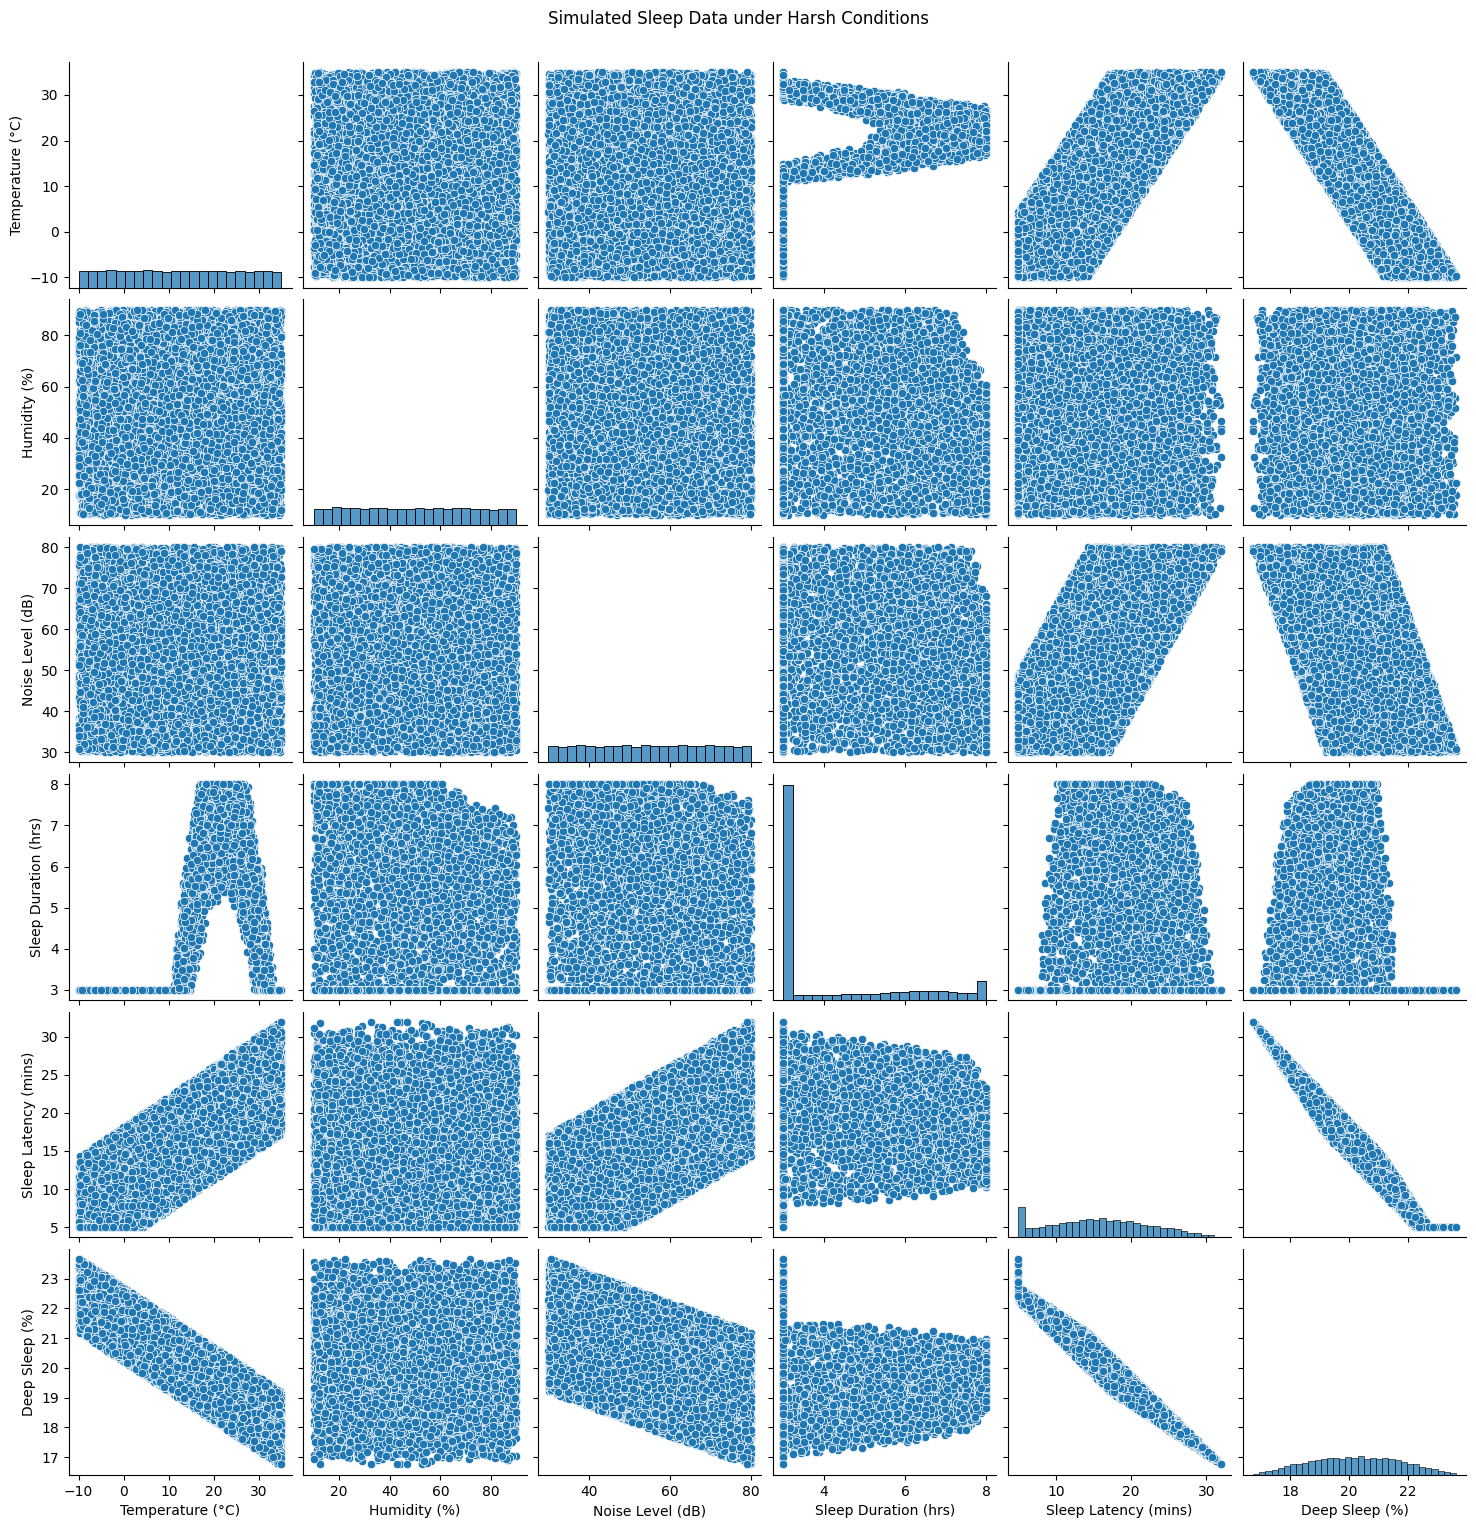

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

n_samples = 10000 
temperature = np.random.uniform(-10, 35, n_samples)
humidity = np.random.uniform(10, 90, n_samples)
noise = np.random.uniform(30, 80, n_samples)

sleep_duration = 8 - 0.05 * (temperature - 22)**2 - 0.03 * (humidity - 50) - 0.04 * (noise - 40)
sleep_duration = np.clip(sleep_duration, 3, 8)

sleep_latency = 15 + 0.4 * (temperature - 22) + 0.3 * (noise - 40)
sleep_latency = np.clip(sleep_latency, 5, 60)

deep_sleep_percentage = 20 - 0.1 * (temperature - 22) - 0.05 * (noise - 40)
deep_sleep_percentage = np.clip(deep_sleep_percentage, 5, 25)

df = pd.DataFrame({
    'Temperature (°C)': temperature,
    'Humidity (%)': humidity,
    'Noise Level (dB)': noise,
    'Sleep Duration (hrs)': sleep_duration,
    'Sleep Latency (mins)': sleep_latency,
    'Deep Sleep (%)': deep_sleep_percentage
})

csv_file_path = 'simulated_sleep_data.csv'
df.to_csv(csv_file_path, index=False)
print(f'Data saved to {csv_file_path}')

print(df.head())

sns.pairplot(df)
plt.suptitle('Simulated Sleep Data under Harsh Conditions', y=1.02)
plt.show()
